In [ ]:
!pip install dipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install fury

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf

import os
import math
import time
import numpy as np
import sklearn as sk

import cv2
import nibabel as nib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from skimage.transform import rescale, resize, downscale_local_mean
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import dipy.reconst.dti as dti
from dipy.data import get_sphere
from dipy.viz import window, actor

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL
from keras.models import load_model

from IPython.display import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
interactive = False
filename = '/content/drive/MyDrive/Colab Notebooks/Data/TENSOR_2x2x2.nii'
#se cargan las imagenes
img = nib.load(filename)
data = img.get_fdata()
hdr = img.header
#se obtiene el numero ttotal de imagenes
num_img = data.shape[3]*data.shape[2]
#se reduce la dimension de las imagenes
data = data.reshape(256,256,-1)
#se normalizan las imgenes
dataMax= data.max()
data = data/dataMax

In [ ]:
#se reduce la resolucion de las imagenes
scale = 2
dataLow=data[0:data.shape[0]:scale,0:data.shape[1]:scale,:]
#plt.imshow(dataLow[:,:,11])
dataLowR = tf.image.resize(dataLow, [256, 256], method='bicubic')
dataLowR=np.array(dataLowR)
print("LowRes Data resized",dataLowR.shape)

LowRes Data resized (256, 256, 858)


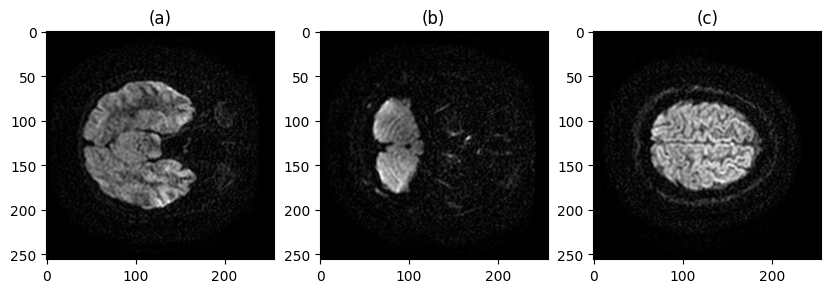

In [ ]:
#Se grafica una pequeña muestra de las imagenes
fig = plt.figure(figsize = [10,10])
ax1= fig.add_subplot(131)
ax1.imshow(data[:,:,300],cmap = "gray")
ax1.set_title("(a)")
ax2= fig.add_subplot(132)
ax2.imshow(data[:,:,123],cmap = "gray")
ax2.set_title("(b)")
ax3= fig.add_subplot(133)
ax3.imshow(data[:,:,720],cmap = "gray")
ax3.set_title("(c)")
plt.show()


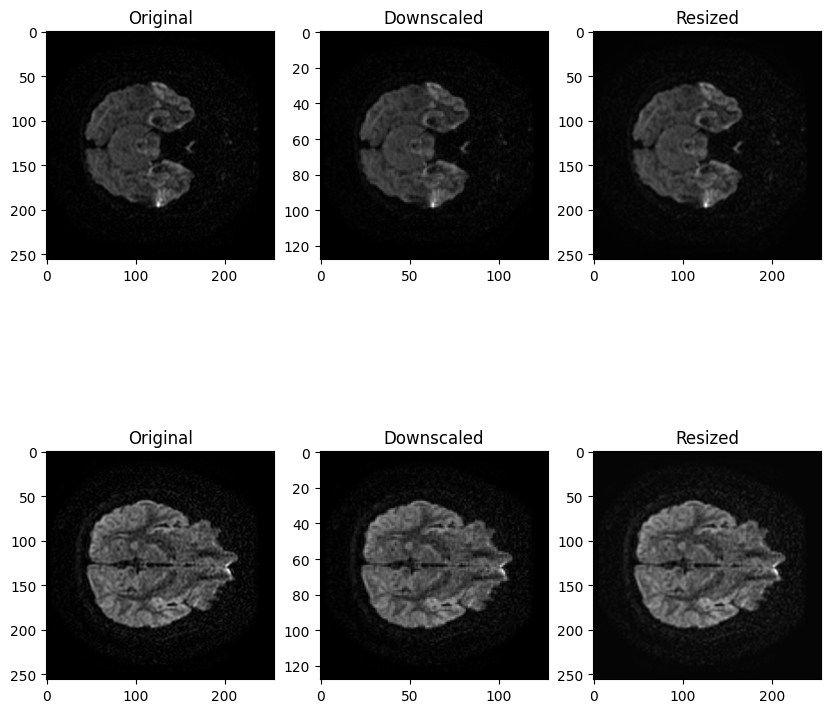

In [ ]:
#Se muestran ejemplos del procesamiento de las imágenes
fig = plt.figure(figsize = [10,10])
ax1= fig.add_subplot(231)
ax1.imshow(data[:,:,280],cmap = "gray")
ax1.set_title("Original")
ax2= fig.add_subplot(232)
ax2.imshow(dataLow[:,:,280],cmap = "gray")
ax2.set_title("Downscaled")
ax3= fig.add_subplot(233)
ax3.imshow(dataLowR[:,:,280],cmap = "gray")
ax3.set_title("Resized")
ax4= fig.add_subplot(234)
ax4.imshow(data[:,:,400],cmap = "gray")
ax4.set_title("Original")
ax5= fig.add_subplot(235)
ax5.imshow(dataLow[:,:,400],cmap = "gray")
ax5.set_title("Downscaled")
ax6= fig.add_subplot(236)
ax6.imshow(dataLowR[:,:,400],cmap = "gray")
ax6.set_title("Resized")

plt.show()

In [ ]:
#se transponen los ejes y se agrega una dismension extra porque es el formato que recibe la red
dataLowR,data = dataLowR.transpose(2,0,1),data.transpose(2,0,1)
dataLowR,data =dataLowR.reshape(-1,dataLowR.shape[1],dataLowR.shape[2],1),data.reshape(-1,data.shape[1],data.shape[2],1)
print("data shape:",data.shape)
print("datalowR shape:",dataLowR.shape)
#Se hace la separacion de datos es training y test teniendo una separacion de 85% y 15% respectivamente
trainX,testX,trainY,testY = train_test_split(dataLowR,data,test_size = 0.15,random_state = 2024)
print("TrainX shape:",trainX.shape)
print("TrainY shape:",trainY.shape)

data shape: (858, 256, 256, 1)
datalowR shape: (858, 256, 256, 1)
TrainX shape: (729, 256, 256, 1)
TrainY shape: (729, 256, 256, 1)


In [ ]:
#se crea el modelo
def build_Model():
	SRCNN = Sequential()
	SRCNN.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5),padding='same',use_bias=True,input_shape=(256, 256, 1),kernel_initializer='Orthogonal',activation='relu'))
	SRCNN.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3),padding='same',use_bias=True,kernel_initializer='Orthogonal', activation='relu'))
	SRCNN.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3),padding='same',use_bias=True,kernel_initializer='Orthogonal',activation='relu'))
	SRCNN.add(tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3),padding='same',use_bias=True,kernel_initializer='Orthogonal',activation='relu'))
	# Optimizer
	optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
	# Compile model
	SRCNN.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
	return SRCNN

model = build_Model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 32)      18464     
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 1)       289       
                                                                 
Total params: 57,345
Trainable params: 57,345
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#se entrena el modelo
time_start = time.time()
model_train=model.fit(trainX,trainY,batch_size = 32,epochs=100, verbose=False,validation_split=0.177)
time_end = time.time()
#model.save('modelCnn100.keras')

In [ ]:
#En caso de quere cargar el modelo

model = load_model('/content/drive/MyDrive/Colab Notebooks/Data/modelVDSR500epochs.keras')
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_20[0][0]']              
                                )                                                           

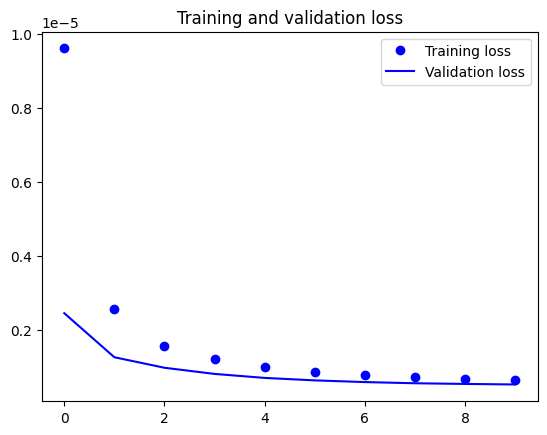

In [ ]:
#se muestra la grafica de train vs validation loss
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(10)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
print("Tiempo de entrenamiento: ",time_end - time_start, "segundos" )
#Se definene las funciones de metricas
def psnr(imagenesGT, imagenesPred):
  psnrGlobal = []
  for i in range(len(imagenesGT)):
    psnr = cv2.PSNR(imagenesGT[i], imagenesPred[i])
    psnrGlobal.append(psnr)
  psnrGlobal = np.array(psnrGlobal)
  return (psnrGlobal.mean(),psnrGlobal.std())


def rmse(imagenesGT, imagenesPred):
  rmseGlobal = []
  for i in range(len(imagenesGT)):
    rmse = np.sqrt(np.mean((imagenesGT[i] - imagenesPred[i])**2))
    rmseGlobal.append(rmse)
  rmseGlobal = np.array(rmseGlobal)
  return (rmseGlobal.mean(),rmseGlobal.std())

def mse(imagenesGT, imagenesPred):
  mseGlobal = []
  for i in range(len(imagenesGT)):
    mse = np.mean((imagenesGT[i] - imagenesPred[i])**2)
    mseGlobal.append(mse)
  mseGlobal = np.array(mseGlobal)
  return (mseGlobal.mean(),mseGlobal.std())

def ssim_(imagenesGT, imagenesPred):
  ssimGlobal = []
  for i in range(len(imagenesGT)):
    ssim_index = ssim(imagenesGT[i], imagenesPred[i], data_range=imagenesPred[i].max() - imagenesPred[i].min(), multichannel=True)
    ssimGlobal.append(ssim_index)
  ssimGlobal = np.array(ssimGlobal)
  return (ssimGlobal.mean(),ssimGlobal.std())
print('metrics')
ypred = model.predict(testX)


metrics
5/5 [==============================] - 6s 406ms/step


In [ ]:
#se definen las funciones de mascara
def create_mask(img):
  img = np.array(img)
  img2 = img*255
  # Convertir la imagen a escala de grises
  gray = img2.astype("uint8")
  # Calcular el umbral Otsu para la imagen en escala de grises
  _,thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) 

  # Encontrar los contornos de la imagen binaria
  contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  # Encontrar el contorno más grande
  max_contour = max(contours, key=cv2.contourArea)
  # Crear una imagen negra del mismo tamaño que la original
  mask = np.zeros_like(gray)

  # Dibujar el contorno más grande en blanco en la imagen negra
  cv2.drawContours(mask, [max_contour], 0, (255), -1)

  # Dilatar la máscara para ampliar el área de recorte
  kernel = np.ones((15, 15), np.uint8)
  mask = cv2.dilate(mask, kernel, iterations=1)
  return mask


def cut(img, mask):
  # Convertir la imagen a escala de grises
  gray = img.astype("uint8")
  # Aplicar la máscara a la imagen original
  masked_img = cv2.bitwise_and(img, img, mask=mask)

  return masked_img

def recortarSet(imagenes, mask):
  imagenes_recortadas = []
  for i in imagenes:
    imagenes_recortadas.append(cut(i, mask))
  return imagenes_recortadas

In [ ]:
#se recortan los diferentes conjuntos de imagenes
data = np.array(data)


data = data.astype(np.float32)
testY = testY.astype(np.float32)


mask = create_mask(data[480])
data_cut = np.array(recortarSet(data, mask))
ypred_cut = np.array(recortarSet(ypred, mask))
testY_cut = np.array(recortarSet(testY, mask))
dataLowR_cut = np.array(recortarSet(dataLowR, mask))

Text(0.5, 1.0, 'Recorte')

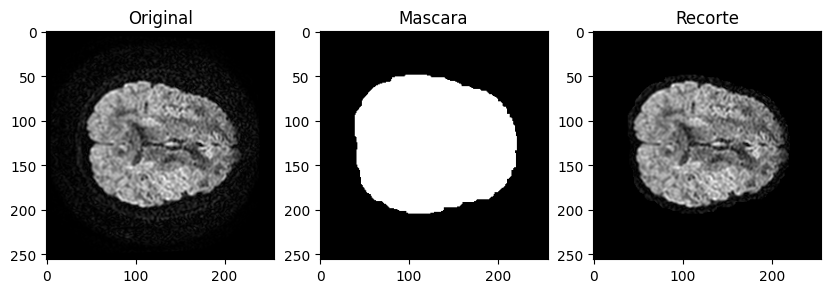

In [ ]:
fig = plt.figure(figsize = [10,10])
ax1= fig.add_subplot(131)
ax1.imshow(data[480],cmap = "gray")
ax1.set_title("Original")
ax2= fig.add_subplot(132)
ax2.imshow(mask,cmap = "gray")
ax2.set_title("Mascara")
ax1= fig.add_subplot(133)
ax1.imshow(data_cut[480],cmap = "gray")
ax1.set_title("Recorte")

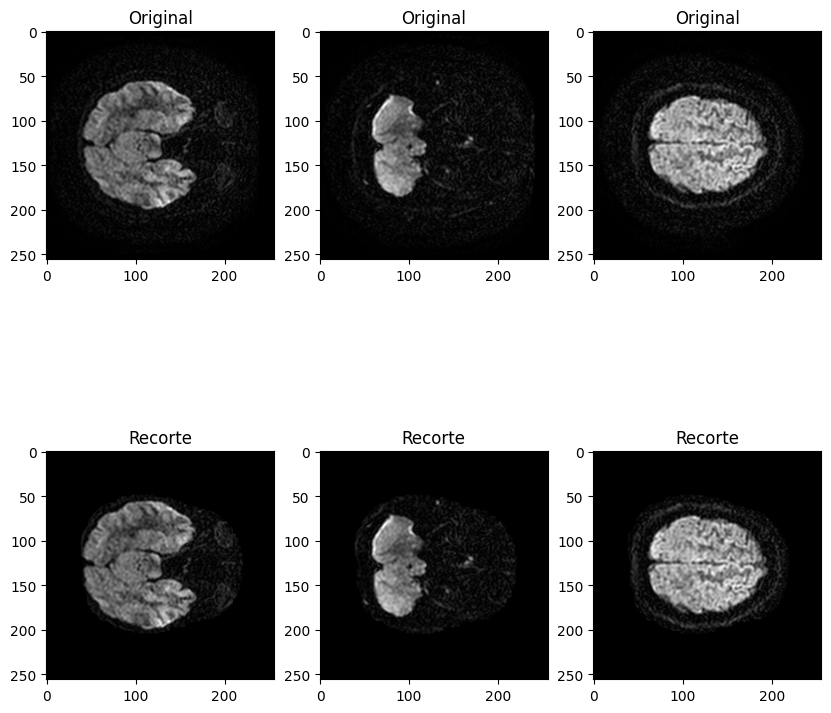

In [ ]:
fig = plt.figure(figsize = [10,10])
ax1= fig.add_subplot(231)
ax1.imshow(data[300],cmap = "gray")
ax1.set_title("Original")
ax2= fig.add_subplot(232)
ax2.imshow(data[140],cmap = "gray")
ax2.set_title("Original")
ax3= fig.add_subplot(233)
ax3.imshow(data[700],cmap = "gray")
ax3.set_title("Original")
ax4= fig.add_subplot(234)
ax4.imshow(data_cut[300],cmap = "gray")
ax4.set_title("Recorte")
ax5= fig.add_subplot(235)
ax5.imshow(data_cut[140],cmap = "gray")
ax5.set_title("Recorte")
ax6= fig.add_subplot(236)
ax6.imshow(data_cut[700],cmap = "gray")
ax6.set_title("Recorte")
plt.show()

In [ ]:
print("Metricas sin recorte")
valssim,stdssim = ssim_(testY, ypred)
print('SSIM:', valssim, "standard deviation: ", stdssim)
valmse,stdmse = mse(testY, ypred)
print('MSE:', valmse, "standard deviation: ", stdmse)
valrmse,stdrmse = rmse(testY, ypred)
print('RMSE:', valrmse, "standard deviation: ", stdrmse)
valpsnr,stdpsnr = psnr(testY, ypred)
print('PSNR:', valpsnr, "standard deviation: ", stdpsnr)

print("Metricas con recorte")
valssim,stdssim = ssim_(testY_cut, ypred_cut)
print('SSIM:', valssim, "standard deviation: ", stdssim)
valmse,stdmse = mse(testY_cut, ypred_cut)
print('MSE:', valmse, "standard deviation: ", stdmse)
valrmse,stdrmse = rmse(testY_cut, ypred_cut)
print('RMSE:', valrmse, "standard deviation: ", stdrmse)
valpsnr,stdpsnr = psnr(testY_cut, ypred_cut)
print('PSNR:', valpsnr, "standard deviation: ", stdpsnr)

Metricas sin recorte


<ipython-input-9-0e97d690c88b>:31: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_index = ssim(imagenesGT[i], imagenesPred[i], data_range=imagenesPred[i].max() - imagenesPred[i].min(), multichannel=True)


SSIM: 0.96269697 standard deviation:  0.010697851
MSE: 3.9862869e-07 standard deviation:  1.7248716e-07
RMSE: 0.00061630685 standard deviation:  0.00013709335
PSNR: 112.58116850739181 standard deviation:  2.1639238801582166
Metricas con recorte
SSIM: 0.98427314 standard deviation:  0.007891855
MSE: 1.9062685e-07 standard deviation:  1.13196585e-07
RMSE: 0.00042559745 standard deviation:  9.743544e-05
PSNR: 115.74294936126888 standard deviation:  1.7839001386752602


In [ ]:
def backTo4D(img):
  """
  Funcion que dado un conjunto de imagnes con dimensiones (858,256,256)
  lo convierte a (256,256,33,26)
  """
  nimg =  img.reshape(858,256,256)
  nimg = nimg.transpose(1,2,0)
  nimg = nimg.reshape(256,256,33,26)
  return nimg

In [ ]:
#Se obtiene los valores propios y vectores propios de los tensores
bvals, bvecs = read_bvals_bvecs('/content/drive/MyDrive/Colab Notebooks/Data/TENSOR_2x2x2.bval', '/content/drive/MyDrive/Colab Notebooks/Data/TENSOR_2x2x2.bvec')

data_cut4 = backTo4D(data_cut)
gtab = gradient_table(bvals, bvecs)
tensorm = dti.TensorModel(gtab)
tenfitdata = tensorm.fit(data_cut4)

In [ ]:
dataLowpred = model.predict(dataLowR)
dataLow_cut = np.array(recortarSet(dataLowpred, mask))

dataLow4 = backTo4D(dataLow_cut)
gtab = gradient_table(bvals, bvecs)
tensorm = dti.TensorModel(gtab)
tenfitdatalow = tensorm.fit(dataLow4)

27/27 [==============================] - 15s 575ms/step


Text(0.5, 1.0, 'SRCNN')

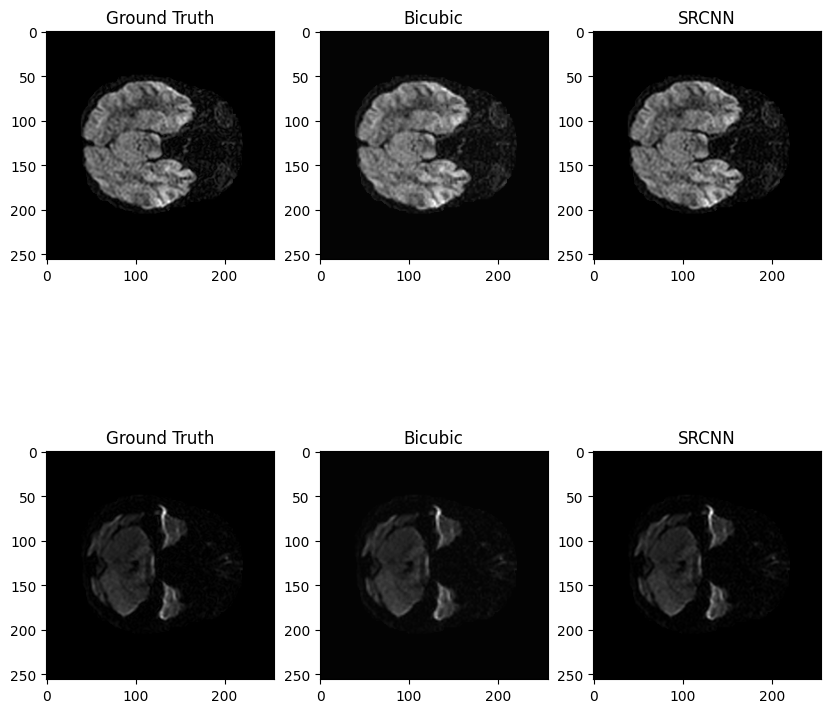

In [ ]:
fig = plt.figure(figsize = [10,10])
ax1= fig.add_subplot(231)
ax1.imshow(data_cut[300],cmap = "gray")
ax1.set_title("Ground Truth")
ax2= fig.add_subplot(232)
ax2.imshow(dataLowR_cut[300],cmap = "gray")
ax2.set_title("Bicubic")
ax3= fig.add_subplot(233)
ax3.imshow(dataLow_cut[300],cmap = "gray")
ax3.set_title("SRCNN")
ax4= fig.add_subplot(234)
ax4.imshow(data_cut[210],cmap = "gray")
ax4.set_title("Ground Truth")
ax5= fig.add_subplot(235)
ax5.imshow(dataLowR_cut[210],cmap = "gray")
ax5.set_title("Bicubic")
ax6= fig.add_subplot(236)
ax6.imshow(dataLow_cut[210],cmap = "gray")
ax6.set_title("SRCNN")

Text(0.5, 1.0, 'SRCNN')

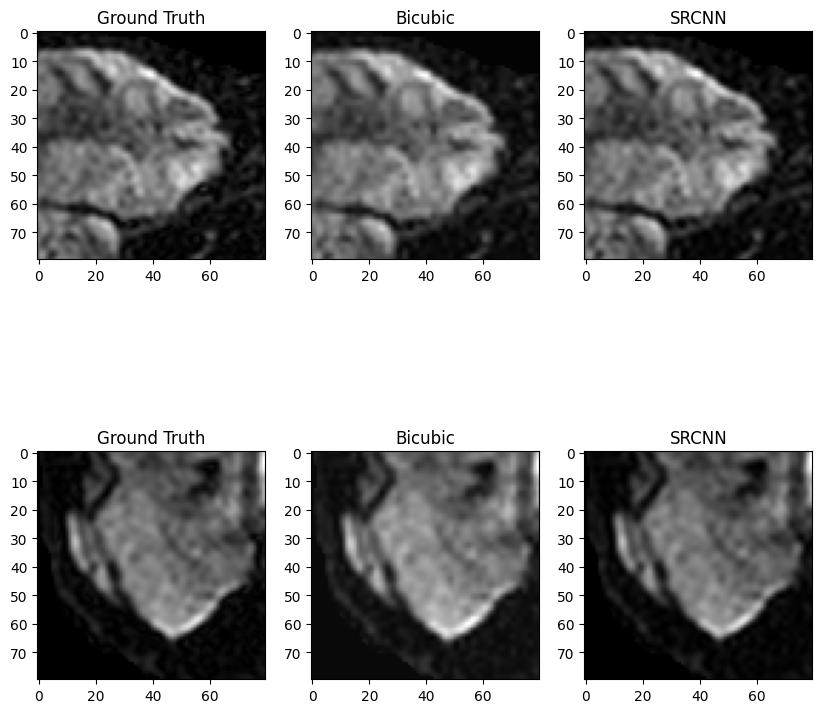

In [ ]:
fig = plt.figure(figsize = [10,10])
ax1= fig.add_subplot(231)
ax1.imshow(data_cut[300,50:130,100:180],cmap = "gray")
ax1.set_title("Ground Truth")
ax2= fig.add_subplot(232)
ax2.imshow(dataLowR_cut[300,50:130,100:180],cmap = "gray")
ax2.set_title("Bicubic")
ax3= fig.add_subplot(233)
ax3.imshow(dataLow_cut[300,50:130,100:180],cmap = "gray")
ax3.set_title("SRCNN")
ax4= fig.add_subplot(234)
ax4.imshow(data_cut[210,120:200,40:120],cmap = "gray")
ax4.set_title("Ground Truth")
ax5= fig.add_subplot(235)
ax5.imshow(dataLowR_cut[210,120:200,40:120],cmap = "gray")
ax5.set_title("Bicubic")
ax6= fig.add_subplot(236)
ax6.imshow(dataLow_cut[210,120:200,40:120],cmap = "gray")
ax6.set_title("SRCNN")

In [ ]:
#se calcula la norma de frobenius
fnorm = dti.norm(tenfitdata.quadratic_form - tenfitdatalow.quadratic_form)
print("mean: ",fnorm.mean(), " std: ", fnorm.std())

mean:  0.0001103962884138639  std:  0.00030693579026998144


In [ ]:
#se calcula el MSE de FA
FAdata = tenfitdata.fa.transpose(2,0,1)
FApred = tenfitdatalow.fa.transpose(2,0,1)
valfa,stdfa = mse(FAdata, FApred)
print('MSE de FA:', valfa, "standard deviation: ", stdfa)

(256, 256, 33)
MSE de FA: 0.012847793844393895 standard deviation:  0.007957065010559216


In [ ]:
#se obtiene las imagenes de los mapas de anisotropia fraccional
FA1 = tenfitdata.fa 
FA1[np.isnan(FA1)] = 0
FA1 = np.clip(FA1, 0, 1)
RGB = dti.color_fa(FA1, tenfitdata.evecs)
sphere = dpd.default_sphere
scene = window.Scene()
evalsdata = tenfitdata.evals[13:43, 44:74, 20:21]
evecsdata = tenfitdata.evecs[13:43, 44:74, 20:21]
cfa = RGB[13:43, 44:74, 20:21]
#cfa /= cfa.max()

scene.add(actor.tensor_slicer(evalsdata, evecsdata, scalar_colors=cfa, sphere=sphere,
                              scale=0.3))

print('Saving illustration as tensor_ellipsoids.png')
window.record(scene, n_frames=1, out_path='tensor_ellipsoids.png',
              size=(600, 600))
if interactive:
    window.show(scene)